# Arabic Mental Health Chatbot Fine-tuning

## Overview

This notebook demonstrates the fine-tuning of a Meta-Llama-3-8B-Instruct model for an Arabic mental health chatbot. The chatbot is designed to provide supportive conversations and guidance to users while acknowledging the user's mental state.


In [61]:
pip install pyarabic

In [62]:
!pip install arabic_reshaper
!pip install python-bidi

In [110]:
pip install azure-ai-textanalytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.6/298.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 18.9 MB/s eta 0:00:00


In [103]:
%pip install \
    datasets \
    evaluate \
    rouge_score\
    loralib \
    evaluate \
    accelerate \
    bitsandbytes \
    trl \
    peft \
    -U --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.8 MB/s eta 0:00:0

In [102]:
from huggingface_hub import login
from google.colab import userdata
secret_label = "HFHub"
secret_value = userdata.get(secret_label)
login(token=secret_value)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


**Imports**

In [104]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [63]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
import evaluate
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import pickle
import string
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset

The dataset used is the "arabictherapydataset" from Huggingface, [dataset link](https://huggingface.co/datasets/Fego12/arabictherapydataset).The dataset was collected from Altibbi.com and IslamWeb. It contains conversations between users and therapists, along with a column indicating the mental state of the user. A prompt is added for the system role to define the chatbot's persona.


In [64]:
import pandas as pd

df = pd.read_csv("hf://datasets/Fego12/arabictherapydataset/therapy arabic2.csv")

In [65]:
df

,question,answer,prompt
0,هل يوجد مراحل لمرض الزهايمر و ما هي المراحل ال...,يعد مرض الزهايمر من الامراض المزمنه التي تتقدم...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
1,يعاني والدي من صعوبه في الحركه ومشاكل في الذاك...,علي الرغم من ان حالات مرض الزهايمر قد يظهر فيه...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
2,اعاني من الرهاب الاجتماعي حيث انني لااصعد الي ...,الامر يحتاج العرض علي معالج سلوكي للتدريب علي ...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
3,انا حامل بشهر السادس وانا قبل احمل مره احب زوج...,اعراض اكتءابيه يلزم مراجعه طبيب حتي لا يتضرر ا...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
4,تم تشخيص والدي انه يعاني من مرض الزهايمر المرح...,تختلف مده استمرار كل مرحله من مراحل الزهايمر م...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
...,...,...,...
11222,السلام عليكم ورحمه الله وبركاته عمري سنه ومتز...,السلام عليكم ورحمه الله وبركاته عمري سنه ومتز...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
11223,السلام عليكم ورحمه الله وبركاته انا معجبه بشخص...,السلام عليكم ورحمه الله وبركاته انا معجبه بشخص...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
11224,السلام عليكم انا شاب نشات في جو من المشاكل وال...,السلام عليكم انا شاب نشات في جو من المشاكل وال...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...
11225,السلام عليكم انا فتاه ابلغ من العمر ٢٨ عاما من...,السلام عليكم انا فتاه ابلغ من العمر ٢٨ عاما من...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...


In [66]:
#we have found that thers's some rows have the same question and answer values
#check these rows

for i in range(len(df)):
  if df.iloc[i]['question'] == df.iloc[i]['answer']:
    print(i)


9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
1

In [67]:
#the rows from 9875 to the end have the question duplicated in the answer column so we will drop them
df = df.drop(df.index[9875:])

In [68]:
#we have labeled the dataset to help in sentiment analysis by classify the mental state of the user
import pandas as pd
df_state= pd.read_csv('/content/quesion_state.csv')
df_state.head()

,question,state
0,هل يوجد مراحل لمرض الزهايمر و ما هي المراحل ال...,قلق على الصحة
1,يعاني والدي من صعوبه في الحركه ومشاكل في الذاك...,قلق على الصحة
2,اعاني من الرهاب الاجتماعي حيث انني لااصعد الي ...,الارتباك
3,انا حامل بشهر السادس وانا قبل احمل مره احب زوج...,الوحدة
4,تم تشخيص والدي انه يعاني من مرض الزهايمر المرح...,السعادة


In [69]:
df['state']=df_state['state']
df.head()

,question,answer,prompt,state
0,هل يوجد مراحل لمرض الزهايمر و ما هي المراحل ال...,يعد مرض الزهايمر من الامراض المزمنه التي تتقدم...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...,قلق على الصحة
1,يعاني والدي من صعوبه في الحركه ومشاكل في الذاك...,علي الرغم من ان حالات مرض الزهايمر قد يظهر فيه...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...,قلق على الصحة
2,اعاني من الرهاب الاجتماعي حيث انني لااصعد الي ...,الامر يحتاج العرض علي معالج سلوكي للتدريب علي ...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...,الارتباك
3,انا حامل بشهر السادس وانا قبل احمل مره احب زوج...,اعراض اكتءابيه يلزم مراجعه طبيب حتي لا يتضرر ا...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...,الوحدة
4,تم تشخيص والدي انه يعاني من مرض الزهايمر المرح...,تختلف مده استمرار كل مرحله من مراحل الزهايمر م...,أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم ...,السعادة


In [70]:
#we have edited the prompt to include the state of the user
df['prompt']=f'أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم لإجراء محادثات داعمة مع المرضى. سوف تستمع بتمعن إلى مخاوفهم ومشاعرهم، مستخدمًا معرفتك لتوجيه المحادثات وتقديم تقنيات بناءً على المناهج العلاجية الراسخة. من المهم أن تتذكر أنك لا تزال قيد التطوير ولا يمكنك استبدال المعالج البشري، ولكن يمكنك أن تكون موردًا قيمًا للدعم العاطفي والإرشاد مع مراعاة ان حالته النفسية هي : '+ df['state']
df['prompt'][2]

'أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم لإجراء محادثات داعمة مع المرضى. سوف تستمع بتمعن إلى مخاوفهم ومشاعرهم، مستخدمًا معرفتك لتوجيه المحادثات وتقديم تقنيات بناءً على المناهج العلاجية الراسخة. من المهم أن تتذكر أنك لا تزال قيد التطوير ولا يمكنك استبدال المعالج البشري، ولكن يمكنك أن تكون موردًا قيمًا للدعم العاطفي والإرشاد مع مراعاة ان حالته النفسية هي : الارتباك'

In [71]:
#then we add a text column
#THIS IS WHERE YOU CAN ADD THE SPECIAL TOKENS. THIS IS VERY IMPORTANT, AS THERE NEEDS TO BE A CERTAIN TEMPLATE WHEN FEEDING THE DATA TO BE FINETUNED

df['text'] = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n" + df['prompt'] + "<|eot_id|>\n" + "<|start_header_id|>user<|end_header_id|>\n" + df['question'] + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" + df['answer'] + "<|eot_id|>\n"


In [72]:
df['text'][0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nأنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم لإجراء محادثات داعمة مع المرضى. سوف تستمع بتمعن إلى مخاوفهم ومشاعرهم، مستخدمًا معرفتك لتوجيه المحادثات وتقديم تقنيات بناءً على المناهج العلاجية الراسخة. من المهم أن تتذكر أنك لا تزال قيد التطوير ولا يمكنك استبدال المعالج البشري، ولكن يمكنك أن تكون موردًا قيمًا للدعم العاطفي والإرشاد مع مراعاة ان حالته النفسية هي : قلق على الصحة<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\nهل يوجد مراحل لمرض الزهايمر و ما هي المراحل التي يمر بها مريض الزهايمر<|eot_id|><|start_header_id|>assistant<|end_header_id|>يعد مرض الزهايمر من الامراض المزمنه التي تتقدم مع الوقت وتمر في مراحل مختلفه ومن ابرز المراحل التي يمر بها مريض الزهايمر ما يلي مرحله ما قبل السريريه  وهي مرحله تمتد لعده سنوات لا يظهر فيها علي الشخص المصاب اي اعراض مرتبطه بمرض الزهايمر الا انه يتم حدوث تغيرات في الدماغ تسبق ظهور الاعراض مرحله مبكره المرحله البسيطه او المعتدله  حيث يعاني فيها الشخص من بعض النسيان والمشاكل في التركي

In [73]:
#check duplicates
df.duplicated().sum()

3

In [74]:
#remove duplicates
df.drop_duplicates(inplace=True)

In [75]:
df.isnull().sum()


,0
question,1
answer,1
prompt,0
state,0
text,1


In [76]:
#drop nulls
df.dropna(inplace=True)

In [77]:
df.to_csv('arabic_mental_health_QA_stateWprompt.csv', index=False)


## Preprocessing

The notebook performs several preprocessing steps, including:

- Removing punctuations and diacritics.
- Normalizing Arabic text.
- Removing stopwords.
- Tokenizing text.

Remove the Punctuations


In [78]:
arabic_punctuations = '''\t\r\n`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [79]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

Remove Arabic Diacritics

In [80]:
import pyarabic.araby as arabic
import pyarabic.araby_const

In [81]:
def remove_diacritics(text):
    return arabic.strip_harakat(text)

 Normalize Text

In [82]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

Remove Stopwords

In [83]:
arabic_stopwords=stopwords.words('arabic')
def remove_stopwords(text):
    filtered_words = [word for word in text if word not in arabic_stopwords]
    return filtered_words

Tokenize Text

In [84]:
def toknize_arabic(text):
    return word_tokenize(text)

In [85]:
df['Cleaned_question'] = df['question'].apply(remove_punctuations)
df['Cleaned_answer'] = df['answer'].apply(remove_punctuations)


In [86]:
df['Cleaned_question'] = df['Cleaned_question'].apply(remove_diacritics)
df['Cleaned_answer'] = df['Cleaned_answer'].apply(remove_diacritics)


In [87]:
df['Cleaned_question'] = df['Cleaned_question'].apply(normalize_arabic)
df['Cleaned_answer'] = df['Cleaned_answer'].apply(normalize_arabic)


In [88]:
df['Tokenized_question'] = df['Cleaned_question'].apply(toknize_arabic)
df['Tokenized_answer'] = df['Cleaned_answer'].apply(toknize_arabic)

## Exploratory Data Analysis (EDA)

EDA is conducted to visualize word frequencies and the distribution of mental states in the dataset. This includes generating word clouds and bar charts to understand the data patterns.


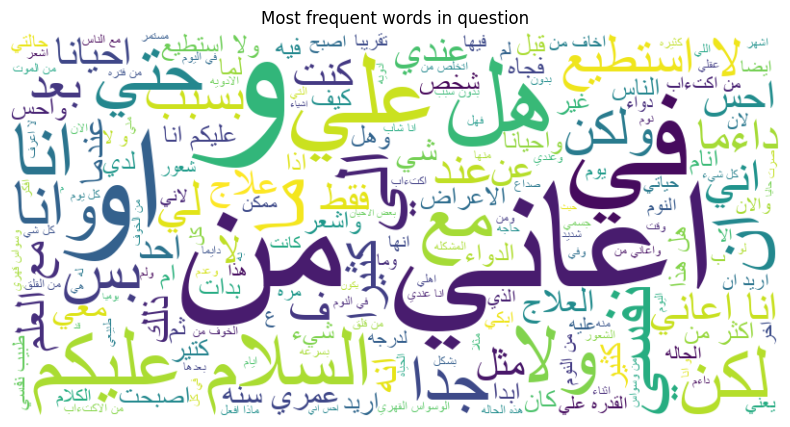

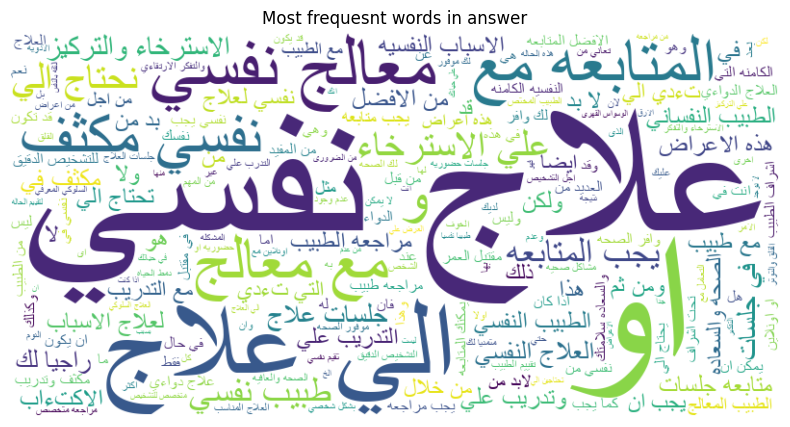

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display

def generate_wordcloud(text_column, title):
    all_words = ' '.join(text_column)
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/content/arial.ttf').generate(all_words)  # Replace with the path to an Arabic font
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_wordcloud(df['Cleaned_question'], 'Most frequent words in question')
generate_wordcloud(df['Cleaned_answer'], 'Most frequesnt words in answer')


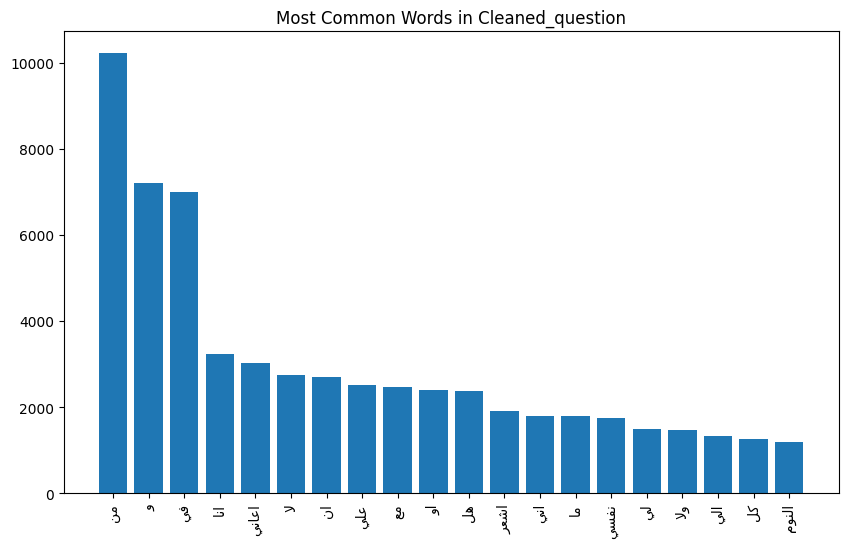

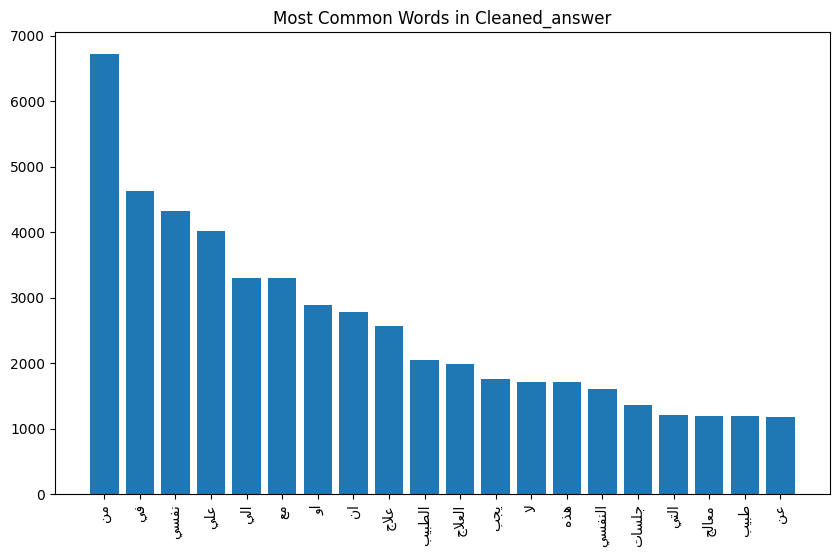

In [96]:
from collections import Counter
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# Function to generate word frequencies
def plot_word_frequencies(text_column, title):
    all_words = ' '.join(text_column).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(20)

    # Plot bar chart
    words, counts = zip(*most_common_words)
    words = [get_display(reshape(word)) for word in words]
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()


# Assuming you have 'Request Detail Stemmed' and 'Notes Stemmed' columns
plot_word_frequencies(df['Cleaned_question'], 'Most Common Words in Cleaned_question')
plot_word_frequencies(df['Cleaned_answer'], 'Most Common Words in Cleaned_answer')

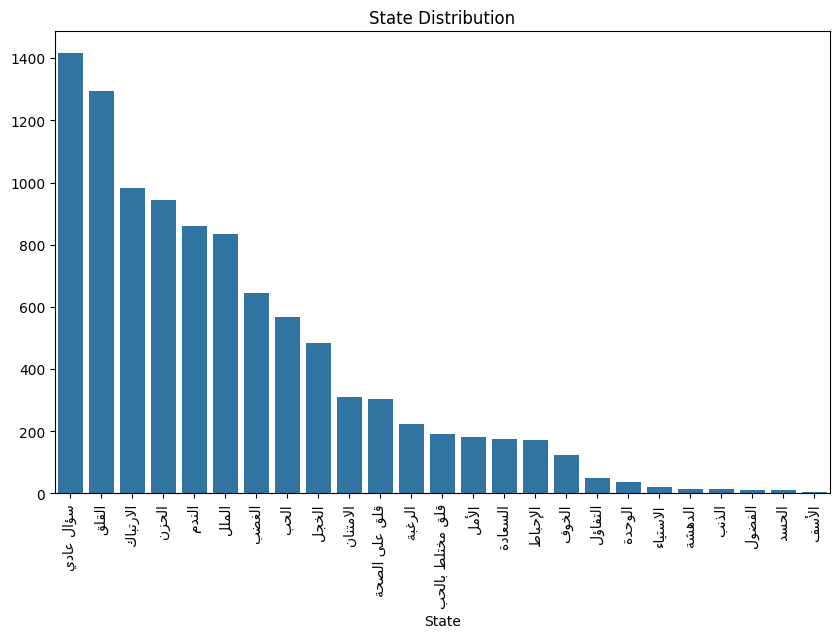

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from arabic_reshaper import reshape
from bidi.algorithm import get_display

state_counts = df['state'].value_counts()

plt.figure(figsize=(10, 6))

# Reshape and display Arabic text correctly
x_labels = [get_display(reshape(label)) for label in state_counts.index]

sns.barplot(x=x_labels, y=state_counts.values)
plt.title('State Distribution')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.show()

## Model and Fine-tuning

The Meta-Llama-3-8B-Instruct model is loaded using the `transformers` library with quantization for memory efficiency. LoRA (Low-Rank Adaptation) is employed to fine-tune the model on the preprocessed dataset.

The training process is performed using the `SFTTrainer` from the `trl` library. Hyperparameters like learning rate, batch size, and epochs are configured in the `TrainingArguments`.



In [105]:
import transformers

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
# Set pad_token as end-of-sentence token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 1050939392
all model parameters: 4540600320
percentage of trainable model parameters: 23.15%


In [ ]:
def tokenize_function(row):
    # Tokenize the conversations
    question = ' '.join(row["Cleaned_question"]) if isinstance(row["Cleaned_question"], list) else row["Cleaned_question"]

    row['input_ids'] = tokenizer(question, padding="max_length", truncation=True, max_length = 128, return_tensors="pt").input_ids[0]

    # Assuming "answer" column is already a string, no need for conversion
    row['labels'] = tokenizer(row["Cleaned_answer"], padding="max_length", truncation=True, max_length = 256, return_tensors="pt").input_ids[0]

    return row


# Tokenize the DataFrame
tokenized_df = df.apply(tokenize_function, axis=1)

In [ ]:
# Convert columns to list
tokenized_df['input_ids'] = tokenized_df['input_ids'].apply(lambda x: x.tolist())
tokenized_df['labels'] = tokenized_df['labels'].apply(lambda x: x.tolist())

In [ ]:
tokenized_datasets = dataset.map(tokenize_function)# batched=True, # batch_size=...


In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'answer','prompt','text'])

In [ ]:
# Load LoRA configuration
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
# Set training parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    # per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
#     evaluation_strategy="epoch",
    optim="paged_adamw_32bit",
    save_steps=100,
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
#     max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard"
)

In [ ]:
from peft import get_peft_model, TaskType

peft_model = get_peft_model(model,
                            peft_args)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3407872
all model parameters: 4544008192
percentage of trainable model parameters: 0.07%


In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=peft_model,
    train_dataset=dataset,
#     eval_dataset=test_dataset,
    peft_config=peft_args,
    dataset_text_field="text",
#     max_seq_length=256,
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


In [ ]:
trainer.train()


Step,Training Loss
100,4.059600
200,3.697200
300,3.500300
400,3.373200
500,3.328900
600,3.263100
700,3.261800
800,3.257400
900,3.182000
1000,3.269400


TrainOutput(global_step=5613, training_loss=3.1385300746899376, metrics={'train_runtime': 4793.9686, 'train_samples_per_second': 2.341, 'train_steps_per_second': 1.171, 'total_flos': 6.47278331953152e+16, 'train_loss': 3.1385300746899376, 'epoch': 1.0})

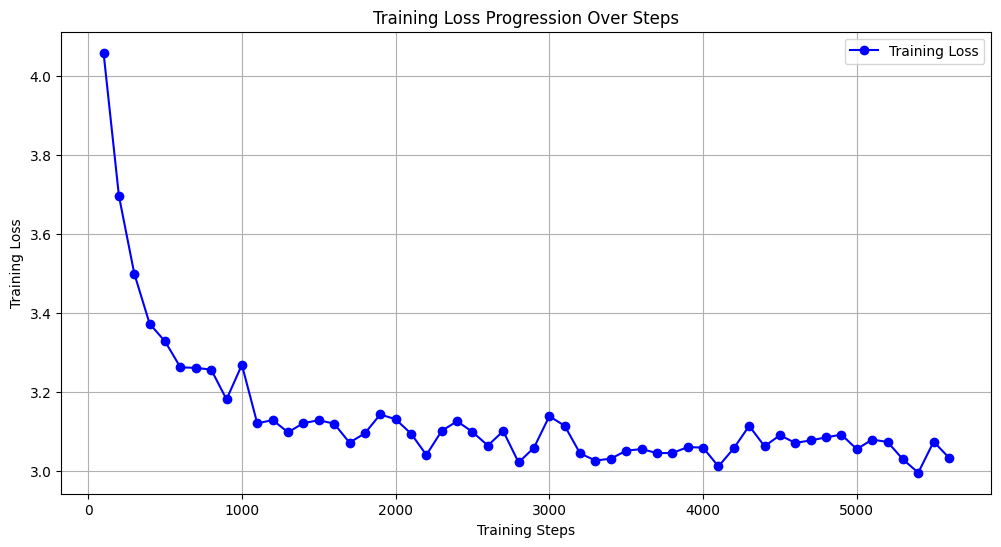

In [108]:
import matplotlib.pyplot as plt

# Assume trainer is the SFTTrainer object from your previous code
# and that training has completed.
training_loss = trainer.state.log_history

# Extract loss values and corresponding steps
steps = []
loss_values = []
for log_entry in training_loss:
  if "loss" in log_entry:
    steps.append(log_entry["step"])
    loss_values.append(log_entry["loss"])


# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(steps, loss_values, label="Training Loss", color='blue', marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Progression Over Steps")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save_pretrained("./llama-3-8B-Arabic")
tokenizer.save_pretrained("./llama-3-8B-Arabic")

('./llama-3-8B-Arabic/tokenizer_config.json',
 './llama-3-8B-Arabic/special_tokens_map.json',
 './llama-3-8B-Arabic/tokenizer.json')

## Inference

A `single_inference` function is defined to interact with the fine-tuned chatbot. It takes a user question as input, constructs a conversation with the system role, and generates a response using the model.


In [ ]:
def single_inference(question):
    messages = [
        {"role": "system", "content": "أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم لإجراء محادثات داعمة مع المرضى. سوف تستمع بتمعن إلى مخاوفهم ومشاعرهم، مستخدمًا معرفتك لتوجيه المحادثات وتقديم تقنيات بناءً على المناهج العلاجية الراسخة. من المهم أن تتذكر أنك لا تزال قيد التطوير ولا يمكنك استبدال المعالج البشري، ولكن يمكنك أن تكون موردًا قيمًا للدعم العاطفي والإرشاد. تحدث بشكل ودود ولطيف . "},
    ]

    messages.append({"role": "user", "content": question})


    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.4,
    #     top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    output = tokenizer.decode(response, skip_special_tokens=True)
    return output

In [ ]:
question = """اعاني من الاكتئاب والتوتر ماذا تنصحني ان افعل؟"""

answer = single_inference(question)

print(f'INPUT QUESTION:\n{question}')
print(f'\n\nModel Answer:\n{answer}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


INPUT QUESTION:
اعاني من الاكتئاب والتوتر ماذا تنصحني ان افعل؟


Model Answer:
أهلاً بك، اعتقدت أنني سأحاول مساعدتك في هذه الحالة.

في البداية، يجب أن أشكرك على أنك تطلب المساعدة، ذلك أن الاكتئاب والتوتر يمكن أن يكونا من أصعب الأعراض التي يمكن أن يتعرض لها الشخص.

في هذه الحالة، سأقترح عليك بعض النصائح التي يمكن أن تساعد في تخفيف المزاج وخفض مستويات التوتر:

1. التمرن في النشاطات الرياضية: يمكن أن يقلل من مستويات التوتر ويزيد من مستويات الحماس والانشغال. يمكنك اختيار النشاطات التي تريدها مثل المشي أو الركض أو اليوغا أو أي نشاط آخر يفيدك.

2. ممارسة الترانيم واليوجا: يمكن أن يساعد في تخفيف المزاج وخفض مستويات التوتر. يمكنك البحث عن فيديوهات يوجا وترانيات متوفره على الانترنت.

3. ممارسة الرياضات القتالية: يمكن أن يقلل من مستوي


In [ ]:

question = """  اعاني من مشكله وهي القلق وقت اختبار السواقه مع اني لا اقلق وقت امتحانات المدرسيه مثلما اختبار السواقه اريد انؤ استفسر حول مهدء القلق هل يساعدني في التركيز وقت اختبار السواقه
 """

answer = single_inference(question)

print(f'INPUT QUESTION:\n{question}')
print(f'\n\nModel Answer:\n{answer}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


INPUT QUESTION:
  اعاني من مشكله وهي القلق وقت اختبار السواقه مع اني لا اقلق وقت امتحانات المدرسيه مثلما اختبار السواقه اريد ان استفسر حول مهدء القلق هل يساعدني في التركيز وقت اختبار السواقه
 


Model Answer:
شكراً لاعترافك بالقلق الذي يصيبك وقت اختبار السواقه، هذا الشعور يعتبر طبيعي لدرجة ما، لكنه يمكن أن يسبب لك الكثير من القلق والتوتر.

حاليا، المهدءات التي تعالج القلق هي من اقصر الادويه التي يمكن استخدامها في هذا الحاله، مثل:

1. لوسانيل (Lorazepam): يعتبر من اقصر المهدءات التي يمكن استخدامها في اختبار السواقه، لكنه يجب استخدامه تحت اشراف طبيب فقط، لان الاستخدام غير المبرر يمكن ان يسبب الاعراض الجانبيه.

2. كلونازيبام (Clonazepam): يعتبر من اقصر المهدءات التي يمكن استخدامها في اختبار السواقه، لكنه يجب استخدامه تحت اشراف طبيب فقط، لان الاستخدام غير المبرر يمكن ان يسبب الاعراض الجانبيه.

3. سيتالوپرام (Citalopram): يعتبر من اقصر المهدءات التي يمكن استخدامها في


##Sentiment Analysis
* Azure Cognitive Services: Uses the Azure Text Analytics client to classify user queries.
* Sentiment Classification: Sends user questions to the classification API endpoint and retrieves the predicted category and confidence score.
* Contextualization: Incorporates the sentiment classification information into the chatbot's prompt, enabling it to generate more tailored responses.

In [ ]:
# from dotenv import load_dotenv
# import os

# Import namespaces
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

def classify_text(query):
    try:
        # Get Configuration Settings
        # load_dotenv()
        ai_endpoint = 'https://sentimentanalysis10.cognitiveservices.azure.com/'
        ai_key = '4kyIh8KGdZYB9j9Yj71gT09yOE3x46rXQpfXilONXKm8CFL7ydK6JQQJ99AJACYeBjFXJ3w3AAAaACOGjCS5'
        project_name = 'MentalHealth10'
        deployment_name = 'MentalHealth'

        # Create client using endpoint and key
        credential = AzureKeyCredential(ai_key)
        ai_client = TextAnalyticsClient(endpoint=ai_endpoint, credential=credential)

        # Prepare the query for classification
        batchedDocuments = [query]

        # Get Classification
        operation = ai_client.begin_single_label_classify(
            batchedDocuments,
            project_name=project_name,
            deployment_name=deployment_name
        )

        document_results = operation.result()

        # Extract classification result
        for classification_result in document_results:
            if classification_result.kind == "CustomDocumentClassification":
                classification = classification_result.classifications[0]
                return classification.category, classification.confidence_score
            elif classification_result.is_error:
                return None, classification_result.error.message

    except Exception as ex:
        return None, str(ex)




In [ ]:
def single_inference(question):
    context = f'أنت معالج بالذكاء الاصطناعي قيد التدريب، مصمم لإجراء محادثات داعمة مع المرضى. سوف تستمع بتمعن إلى مخاوفهم ومشاعرهم، مستخدمًا معرفتك لتوجيه المحادثات وتقديم تقنيات بناءً على المناهج العلاجية الراسخة. من المهم أن تتذكر أنك لا تزال قيد التطوير ولا يمكنك استبدال المعالج البشري، ولكن يمكنك أن تكون موردًا قيمًا للدعم العاطفي والإرشاد مع مراعاة ان حالته النفسية هي : {category}'
    messages = [
        {"role": "system", "content": context },
    ]

    messages.append({"role": "user", "content": question})


    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.4,
    #     top_p=0.9,
    )
    response = outputs[0][input_ids.shape[-1]:]
    output = tokenizer.decode(response, skip_special_tokens=True)
    return output

In [ ]:
# Example usage
question = "أعاني من الرهاب الاجتماعي حيث أنني لا أصعد إلى السبورة ولا أشارك في قسمي بسبب أني لو فعلت لتزايدت ضربات قلبي ولتشتت ذهني وعدم استطاعتي الكلام بصورة واضحة."
category, confidence_score = classify_text(question)
if confidence_score:
    print(f"Query was classified as '{category}' with confidence score {confidence_score}.")
else:
    print(f"An error occurred: {category}")

Query was classified as 'الارتباك' with confidence score 0.79.


In [ ]:
answer = single_inference(question)

print(f'INPUT QUESTION:\n{question}')
print(f'\n\nModel Answer:\n{answer}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


INPUT QUESTION:
أعاني من الرهاب الاجتماعي حيث أنني لا أصعد إلى السبورة ولا أشارك في قسمي بسبب أني لو فعلت لتزايدت ضربات قلبي ولتشتت ذهني وعدم استطاعتي الكلام بصورة واضحة.


Model Answer:
أهلاً بك، أشعر بالقلق والتوتر من خلال ما تحدثت عنه، الرهاب الاجتماعي يمكن أن يكون مشكلة صعبه جداً في حياتك اليوميه، ونتيجه لهذه المشكله هي انك لا تعرف كيف تتصرف في حالات معينه مثل الحضور في الفصل او التحدث امام الناس.

منذ متي بدات مشكلتك هذه؟ هل كانت هناك اي ايام او حالات معينه في حياتك عندما بدات هذه المشكله؟ هل كان هناك اي حدث او شخص معين سبب هذه المشكله؟

كما انني سوف احاول ان اكون داعما لكم في هذه الحاله، هل هناك اي شيء اخر يمكنني ان افعل لكي اعطيكم دعم اكثر؟ هل لديك اي علاقه مع طبيب نفسي او هل لديك اي علاقه مع اي نوع من العلاج النفسي؟

في هذه الحاله، ما الذي يمكنني فعله لكي اتكلم معك في هذا الموضوع؟ هل لديك اي شيء ماذا تريد ان تتعلم عن الرهاب الاجتماعي؟ هل لديك اي شيء
